<h1 style="color:white; background-color:blue; padding:30px;border-radius: 15px;"> 
Prediction Student Test Scores</h1>

In [1]:
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from xgboost import XGBRegressor

# Model Selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error

# Hyperparameter tuning
import optuna

# Global Settings
warnings = __import__("warnings")
warnings.filterwarnings("ignore")

sns.set(style="whitegrid")
RANDOM_STATE = 42

## 1. LOAD DATA

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (630000, 13)
Test shape: (270000, 12)


In [3]:
train.head()

,id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
0,0,21,female,b.sc,7.91,98.8,no,4.9,average,online videos,low,easy,78.3
1,1,18,other,diploma,4.95,94.8,yes,4.7,poor,self-study,medium,moderate,46.7
2,2,20,female,b.sc,4.68,92.6,yes,5.8,poor,coaching,high,moderate,99.0
3,3,19,male,b.sc,2.00,49.5,yes,8.3,average,group study,high,moderate,63.9
4,4,23,male,bca,7.65,86.9,yes,9.6,good,self-study,high,easy,100.0


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630000 entries, 0 to 629999
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                630000 non-null  int64  
 1   age               630000 non-null  int64  
 2   gender            630000 non-null  object 
 3   course            630000 non-null  object 
 4   study_hours       630000 non-null  float64
 5   class_attendance  630000 non-null  float64
 6   internet_access   630000 non-null  object 
 7   sleep_hours       630000 non-null  float64
 8   sleep_quality     630000 non-null  object 
 9   study_method      630000 non-null  object 
 10  facility_rating   630000 non-null  object 
 11  exam_difficulty   630000 non-null  object 
 12  exam_score        630000 non-null  float64
dtypes: float64(4), int64(2), object(7)
memory usage: 62.5+ MB


In [5]:
train.describe()

,id,age,study_hours,class_attendance,sleep_hours,exam_score
count,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000
mean,314999.500000,20.545821,4.002337,71.987261,7.072758,62.506672
std,181865.479132,2.260238,2.359880,17.430098,1.744811,18.916884
min,0.000000,17.000000,0.080000,40.600000,4.100000,19.599000
25%,157499.750000,19.000000,1.970000,57.000000,5.600000,48.800000
50%,314999.500000,21.000000,4.000000,72.600000,7.100000,62.600000
75%,472499.250000,23.000000,6.050000,87.200000,8.600000,76.300000
max,629999.000000,24.000000,7.910000,99.400000,9.900000,100.000000


In [6]:
print("Memory Usage (MB):")
print(train.memory_usage(deep=True).sum() / 1024**2)

Memory Usage (MB):
257.2831563949585


## 2. TARGET ANALYSIS

#### Distribution

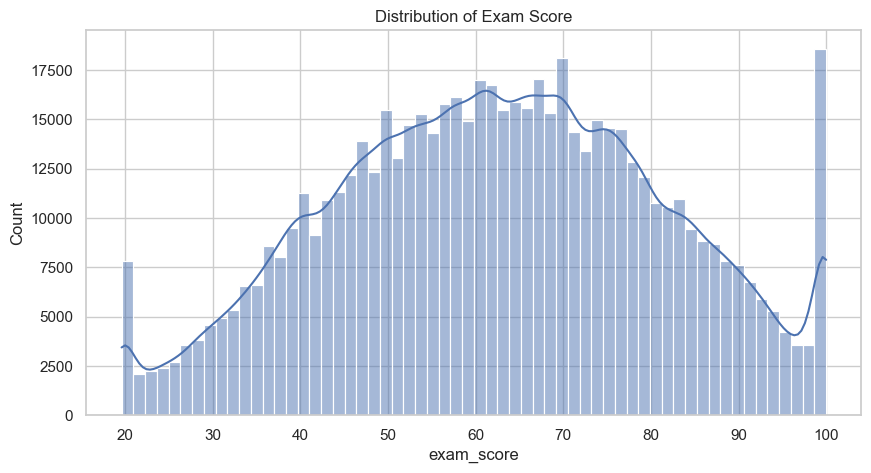

In [7]:
plt.figure(figsize=(10,5))
sns.histplot(train["exam_score"], bins=60, kde=True)
plt.title("Distribution of Exam Score")
plt.show()

#### Skewness & Statistics

In [8]:
print("Mean:", train.exam_score.mean())
print("Std:", train.exam_score.std())
print("Skewness:", train.exam_score.skew())

Mean: 62.506672165079365
Std: 18.91688414632426
Skewness: -0.04827320083537824


#### Q-Q Plot

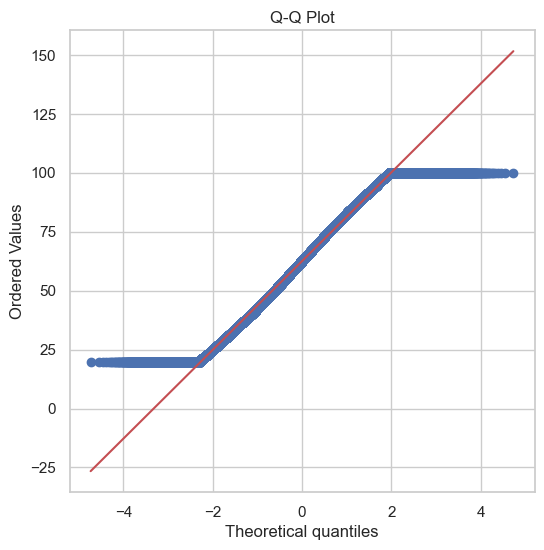

In [9]:
plt.figure(figsize=(6,6))
stats.probplot(train["exam_score"], dist="norm", plot=plt)
plt.title("Q-Q Plot")
plt.show()

#### IQR Outlier Analysis

In [10]:
Q1 = train["exam_score"].quantile(0.25)
Q3 = train["exam_score"].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

print("Lower Bound:", lower)
print("Upper Bound:", upper)

outliers = train[(train["exam_score"] < lower) | (train["exam_score"] > upper)]
print("Number of outliers:", len(outliers))

Lower Bound: 7.549999999999997
Upper Bound: 117.55
Number of outliers: 0


#### Z-Score Analysis

In [11]:
z_scores = np.abs(stats.zscore(train["exam_score"]))
print("Z-score outliers (>3):", (z_scores > 3).sum())

Z-score outliers (>3): 0


## 3. NUMERICAL EDA

#### Histograms

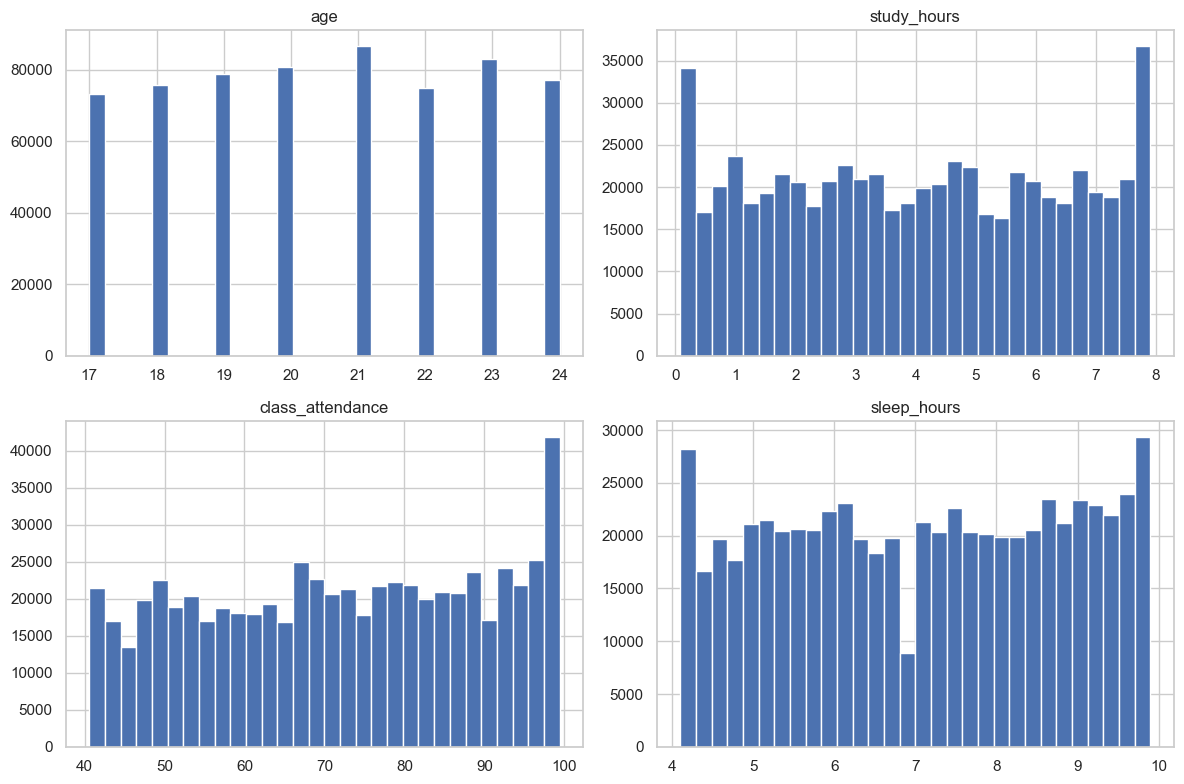

In [12]:
num_cols = train.select_dtypes(include=["int64","float64"]).columns.drop(["id","exam_score"])

train[num_cols].hist(figsize=(12,8), bins=30)
plt.tight_layout()
plt.show()

#### KDE Plots

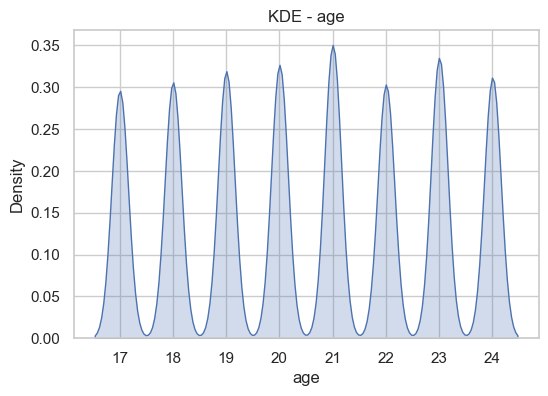

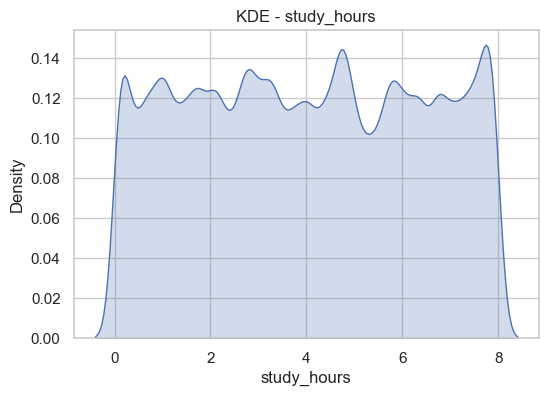

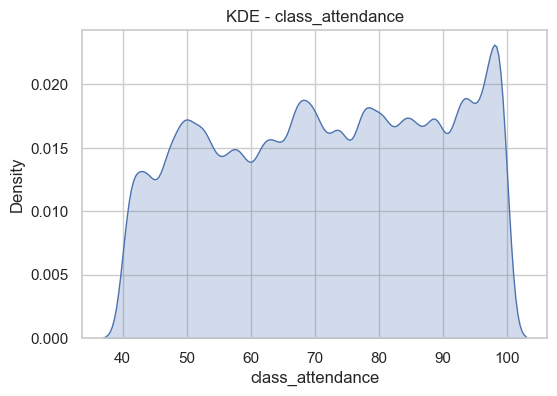

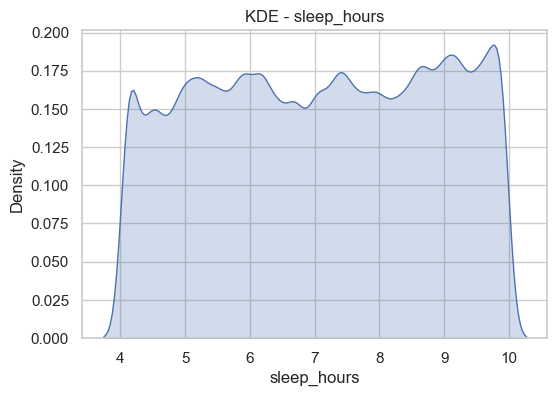

In [13]:
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.kdeplot(train[col], fill=True)
    plt.title(f"KDE - {col}")
    plt.show()

#### Scatter vs Target

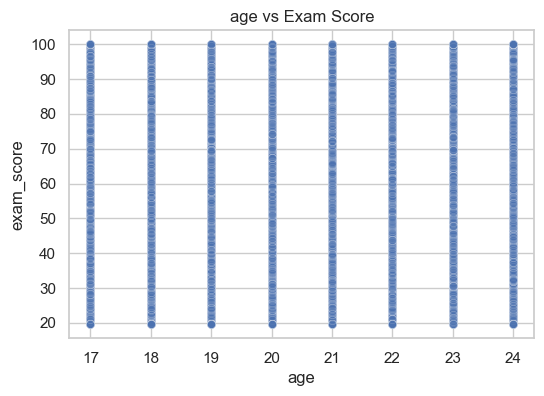

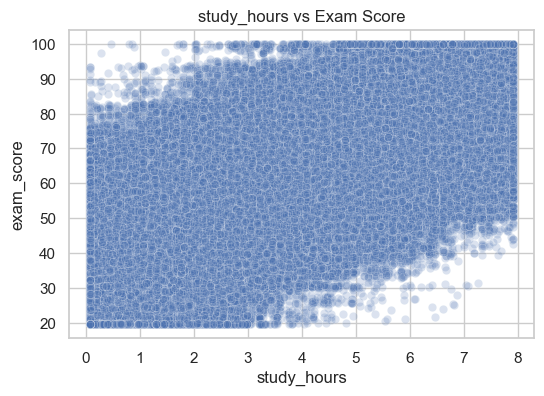

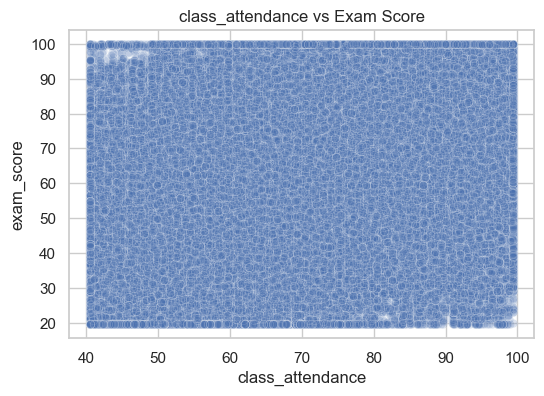

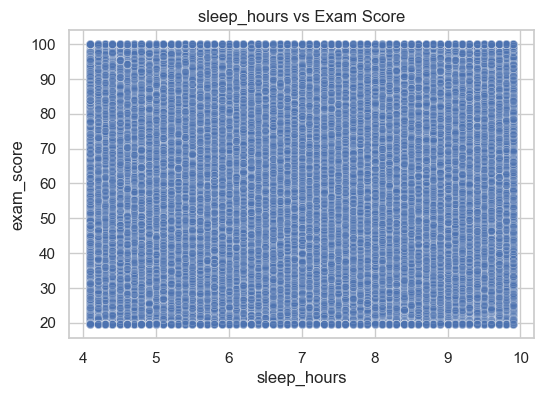

In [14]:
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=train[col], y=train["exam_score"], alpha=0.2)
    plt.title(f"{col} vs Exam Score")
    plt.show()

#### Correlation Heatmap

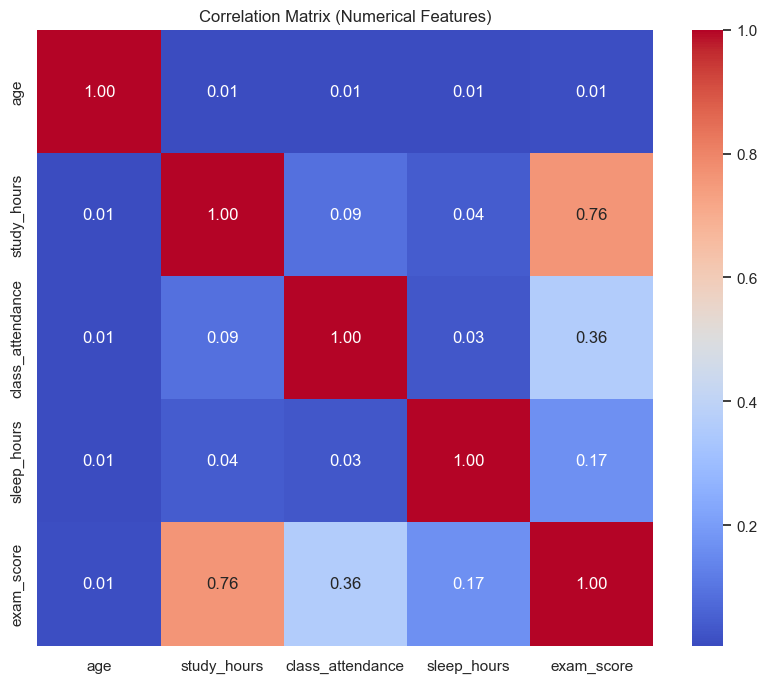

In [15]:
numeric_df = train.select_dtypes(include=["int64", "float64"]).drop(columns=["id"])

plt.figure(figsize=(10,8))
sns.heatmap(numeric_df.corr(),
            annot=True,
            cmap="coolwarm",
            fmt=".2f",
            square=True)
plt.title("Correlation Matrix (Numerical Features)")
plt.show()

#### Feature-Target Correlation Ranking

In [16]:
corr = (
    train
    .select_dtypes(include=["int64","float64"])
    .drop(columns=["id"])
    .corr()["exam_score"]
    .sort_values(ascending=False)
)

print(corr)

exam_score          1.000000
study_hours         0.762267
class_attendance    0.360954
sleep_hours         0.167410
age                 0.010472
Name: exam_score, dtype: float64


## 4. CATEGORICAL EDA

In [17]:
cat_cols = train.select_dtypes(include="object").columns

#### Count Plots

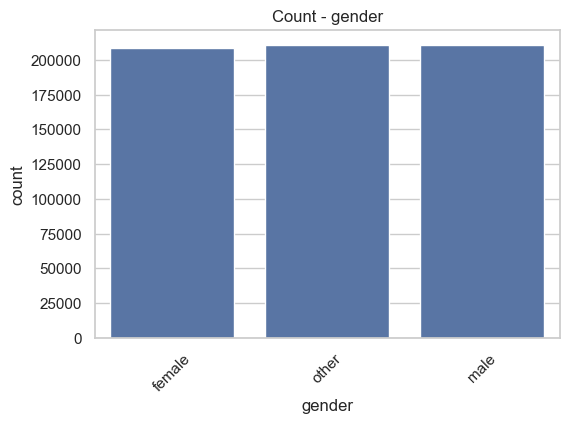

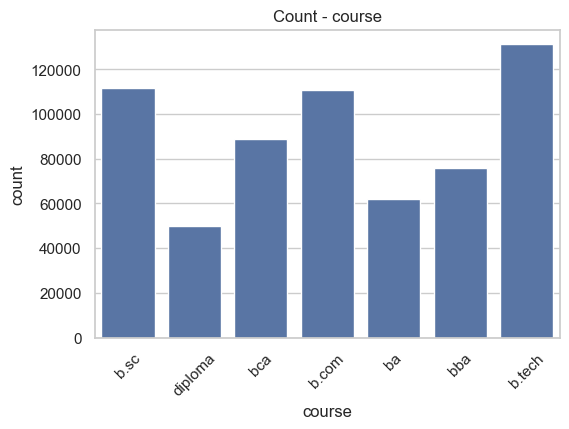

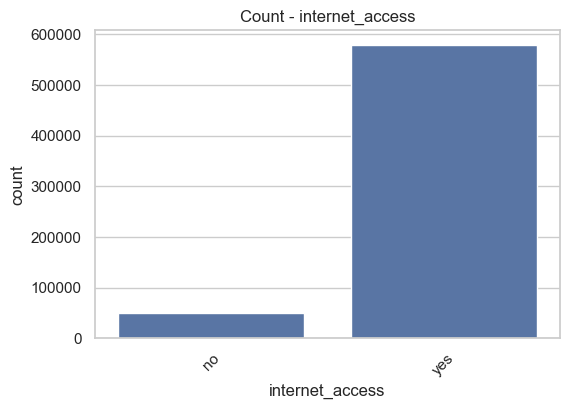

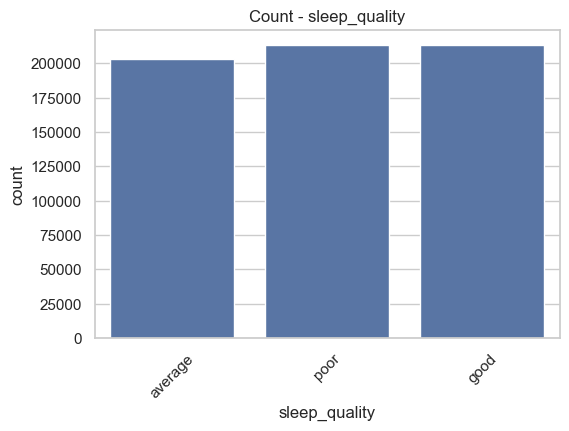

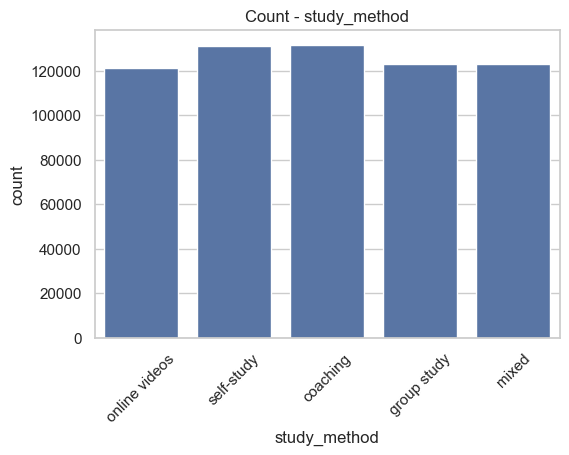

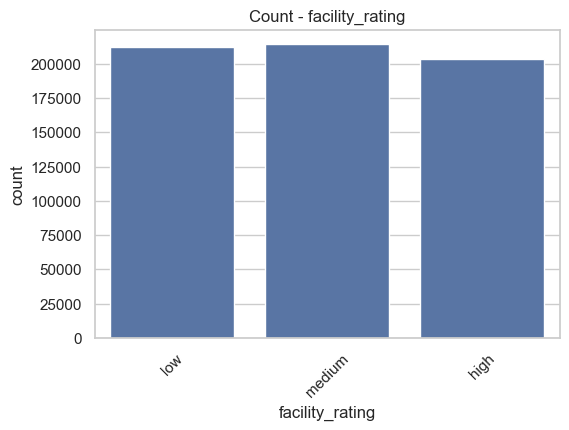

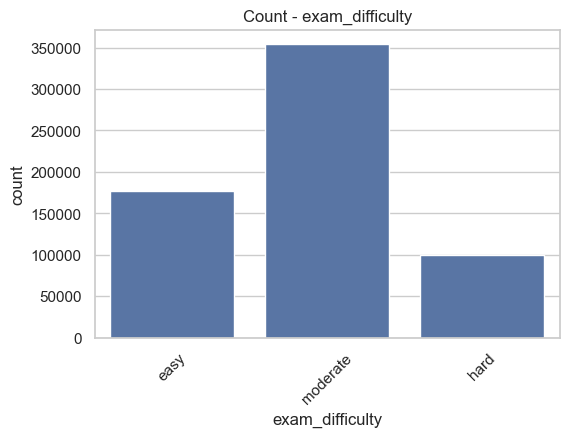

In [18]:
for col in cat_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(data=train, x=col)
    plt.xticks(rotation=45)
    plt.title(f"Count - {col}")
    plt.show()

#### Boxplots vs Target

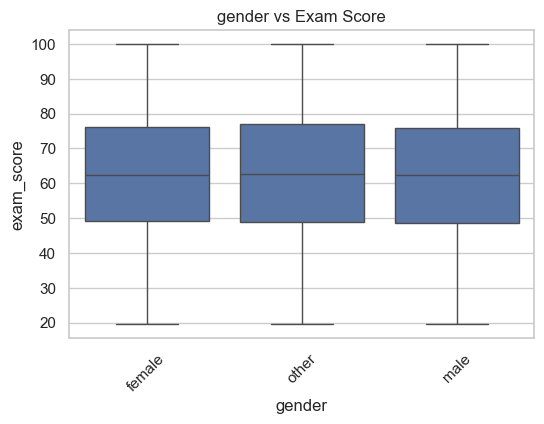

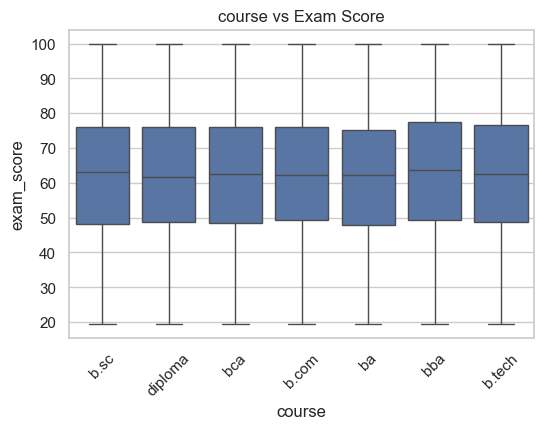

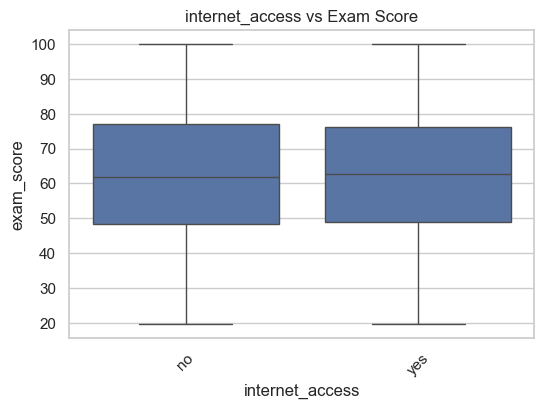

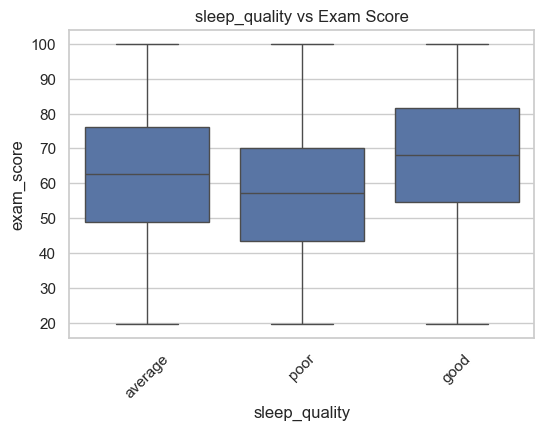

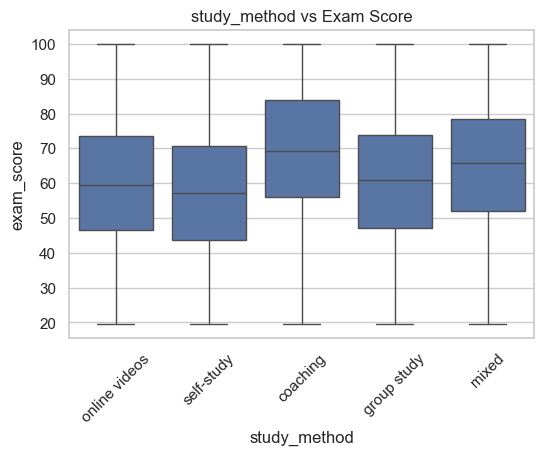

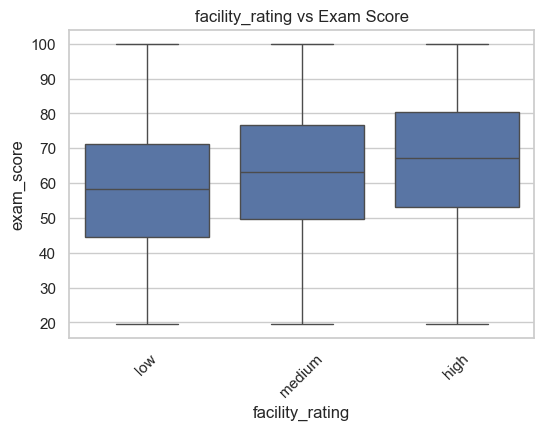

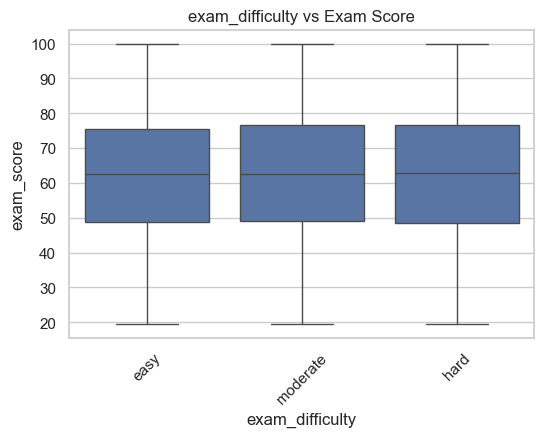

In [19]:
for col in cat_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=col, y="exam_score", data=train)
    plt.xticks(rotation=45)
    plt.title(f"{col} vs Exam Score")
    plt.show()

#### Target Mean by Category

In [20]:
for col in cat_cols:
    print("\n", col)
    print(train.groupby(col)["exam_score"].mean().sort_values())


 gender
gender
male      62.175561
female    62.563220
other     62.781191
Name: exam_score, dtype: float64

 course
course
ba         61.886931
b.sc       62.295491
diploma    62.404354
b.tech     62.519707
b.com      62.537726
bca        62.586227
bba        63.232038
Name: exam_score, dtype: float64

 internet_access
internet_access
no     62.478038
yes    62.509172
Name: exam_score, dtype: float64

 sleep_quality
sleep_quality
poor       56.995470
average    62.662000
good       67.884885
Name: exam_score, dtype: float64

 study_method
study_method
self-study       57.700155
online videos    59.727607
group study      60.531838
mixed            65.101735
coaching         69.266665
Name: exam_score, dtype: float64

 facility_rating
facility_rating
low       57.954546
medium    63.028954
high      66.707126
Name: exam_score, dtype: float64

 exam_difficulty
exam_difficulty
easy        62.214401
moderate    62.606060
hard        62.671693
Name: exam_score, dtype: float64


#### Category Impact on RMSE 

In [21]:

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Baseline: numerical only
num_cols = train.select_dtypes(include=["int64","float64"]).columns.drop(["id","exam_score"])
X_num = train[num_cols]
y = train["exam_score"]

def evaluate_cv(X, y):
    oof = np.zeros(len(X))
    
    for train_idx, val_idx in kf.split(X):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        model = XGBRegressor(
            n_estimators=400,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1
        )
        
        model.fit(X_tr, y_tr)
        oof[val_idx] = model.predict(X_val)
    
    return rmse(y, oof)

baseline_rmse = evaluate_cv(X_num, y)
print("Baseline (Numerical Only) RMSE:", baseline_rmse)

Baseline (Numerical Only) RMSE: 10.454334870057513


#### Evaluate Each Categorical Variable Individually

In [22]:
cat_cols = train.select_dtypes(include="object").columns

category_results = []

for col in cat_cols:
    
    print(f"\nEvaluating: {col}")
    
    encoded = pd.get_dummies(train[[col]])
    X_temp = pd.concat([X_num, encoded], axis=1)
    
    cat_rmse = evaluate_cv(X_temp, y)
    improvement = baseline_rmse - cat_rmse
    
    print(f"RMSE: {cat_rmse:.5f}")
    print(f"Improvement: {improvement:.5f}")
    
    category_results.append({
        "Category": col,
        "RMSE": cat_rmse,
        "Improvement": improvement
    })

results_df = pd.DataFrame(category_results).sort_values("Improvement", ascending=False)
results_df


Evaluating: gender
RMSE: 10.45535
Improvement: -0.00102

Evaluating: course
RMSE: 10.45473
Improvement: -0.00040

Evaluating: internet_access
RMSE: 10.45833
Improvement: -0.00399

Evaluating: sleep_quality
RMSE: 9.81206
Improvement: 0.64228

Evaluating: study_method
RMSE: 9.91648
Improvement: 0.53786

Evaluating: facility_rating
RMSE: 10.04152
Improvement: 0.41282

Evaluating: exam_difficulty
RMSE: 10.45629
Improvement: -0.00195


,Category,RMSE,Improvement
3,sleep_quality,9.812056,0.642279
4,study_method,9.916479,0.537856
5,facility_rating,10.041520,0.412815
1,course,10.454732,-0.000397
0,gender,10.455351,-0.001016
6,exam_difficulty,10.456289,-0.001954
2,internet_access,10.458326,-0.003991


## 5. FEATURE ENGINEERING

In [23]:
def create_features(df):
    df = df.copy()
    
    # Interaction Features
    df['study_x_attendance'] = df['study_hours'] * df['class_attendance']
    df['study_x_sleep'] = df['study_hours'] * df['sleep_hours']
    df['attendance_x_sleep'] = df['class_attendance'] * df['sleep_hours']
    
    df['study_efficiency'] = df['study_hours'] * df['class_attendance'] / 100
    df['study_sleep_ratio'] = df['sleep_hours'] / (df['study_hours'] + 0.5)
    df['attendance_age_ratio'] = df['class_attendance'] / (df['age'] + 1)
    
    # Polynomial
    df['study_hours_sq'] = df['study_hours'] ** 2
    df['attendance_sq'] = df['class_attendance'] ** 2
    
    # Binning
    df['study_hours_bin'] = pd.cut(df['study_hours'],
                                   bins=[-1,2,4,6,10],
                                   labels=[0,1,2,3]).astype(float)
    
    df['attendance_bin'] = pd.cut(df['class_attendance'],
                                  bins=[-1,50,70,85,101],
                                  labels=[0,1,2,3]).astype(float)
    
    df['sleep_hours_bin'] = pd.cut(df['sleep_hours'],
                                   bins=[3,5,7,9,11],
                                   labels=[0,1,2,3]).astype(float)
    
    return df

In [24]:
train_fe = create_features(train)
test_fe = create_features(test)

print("New feature count:", train_fe.shape[1])

New feature count: 24


#### Smoothed Target Encoding

In [25]:
from sklearn.model_selection import KFold

def target_encode_smooth(train_df, test_df, col, target, alpha=10):
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    global_mean = train_df[target].mean()
    
    train_encoded = np.zeros(len(train_df))
    
    for train_idx, val_idx in kf.split(train_df):
        tr = train_df.iloc[train_idx]
        stats = tr.groupby(col)[target].agg(['mean','count'])
        
        smooth = (stats['mean']*stats['count'] + global_mean*alpha) / (stats['count']+alpha)
        train_encoded[val_idx] = train_df.iloc[val_idx][col].map(smooth).fillna(global_mean)
    
    stats_full = train_df.groupby(col)[target].agg(['mean','count'])
    smooth_full = (stats_full['mean']*stats_full['count'] + global_mean*alpha) / (stats_full['count']+alpha)
    
    test_encoded = test_df[col].map(smooth_full).fillna(global_mean)
    
    return train_encoded, test_encoded

In [26]:
important_cats = results_df.head(4)["Category"].tolist()

for col in important_cats:
    train_fe[f"{col}_te"], test_fe[f"{col}_te"] = target_encode_smooth(
        train_fe, test_fe, col, "exam_score"
    )

#### Group Statistical Features

In [27]:
from sklearn.model_selection import KFold
import numpy as np

def add_group_stats_cv(train_df, test_df, group_cols, target_col, n_folds=5):
    
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    global_mean = train_df[target_col].mean()
    
    for col in group_cols:
        
        train_df[f'{col}_mean'] = 0.0
        train_df[f'{col}_std'] = 0.0
        
        # ---- OOF computation for train ----
        for train_idx, val_idx in kf.split(train_df):
            
            tr = train_df.iloc[train_idx]
            val = train_df.iloc[val_idx]
            
            stats = tr.groupby(col)[target_col].agg(['mean', 'std'])
            
            train_df.loc[val.index, f'{col}_mean'] = \
                val[col].map(stats['mean']).fillna(global_mean)
            
            train_df.loc[val.index, f'{col}_std'] = \
                val[col].map(stats['std']).fillna(0)
        
        # ---- Full computation for test ----
        full_stats = train_df.groupby(col)[target_col].agg(['mean', 'std'])
        
        test_df[f'{col}_mean'] = \
            test_df[col].map(full_stats['mean']).fillna(global_mean)
        
        test_df[f'{col}_std'] = \
            test_df[col].map(full_stats['std']).fillna(0)
    
    return train_df, test_df


# Apply leakage-free group stats
group_cols = [
    'course',
    'study_method',
    'exam_difficulty',
    'facility_rating'
]

train_fe, test_fe = add_group_stats_cv(
    train_fe,
    test_fe,
    group_cols,
    target_col='exam_score',
    n_folds=5
)

In [28]:
# group_cols = ['course','study_method','exam_difficulty','facility_rating']

# for col in group_cols:
#     stats = train.groupby(col)['exam_score'].agg(['mean','std'])
    
#     train_fe[f'{col}_mean'] = train_fe[col].map(stats['mean'])
#     train_fe[f'{col}_std'] = train_fe[col].map(stats['std'])
    
#     test_fe[f'{col}_mean'] = test_fe[col].map(stats['mean'])
#     test_fe[f'{col}_std'] = test_fe[col].map(stats['std'])

In [29]:
exclude_cols = ['id','exam_score',
                'gender','course','internet_access',
                'sleep_quality','study_method',
                'facility_rating','exam_difficulty']

feature_cols = [c for c in train_fe.columns if c not in exclude_cols]

print("Final feature count:", len(feature_cols))

Final feature count: 27


## 6. MODEL TRAINING WITH OOF

In [30]:
SEED = 42
N_FOLDS = 5

kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

X_train = train_fe[feature_cols].values
y_train = train_fe['exam_score'].values
X_test = test_fe[feature_cols].values
test_ids = test_fe['id'].values

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

#### Training Function

In [31]:
def train_model(model_fn, X, y, X_test, model_name, params=None):
    
    oof_preds = np.zeros(len(X))
    test_preds = np.zeros(len(X_test))
    scores = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        
        X_tr, X_val = X[train_idx], X[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]

        model = model_fn(params)
        model.fit(X_tr, y_tr)

        oof_preds[val_idx] = model.predict(X_val)
        test_preds += model.predict(X_test) / N_FOLDS

        fold_rmse = rmse(y_val, oof_preds[val_idx])
        scores.append(fold_rmse)

        print(f"{model_name} - Fold {fold+1}: {fold_rmse:.5f}")

    cv_rmse = rmse(y, oof_preds)
    print(f"\n{model_name}: Overall CV RMSE = {cv_rmse:.5f}")
    
    return oof_preds, test_preds, cv_rmse

## 7. BASELINE & ADVANCED MODELS

#### Model 1: LightGBM

In [32]:
import lightgbm as lgb
import xgboost as xgb

lgb_params = {
    'n_estimators': 1200,
    'learning_rate': 0.03,
    'max_depth': 8,
    'num_leaves': 64,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.5,
    'reg_lambda': 5.0,
    'random_state': SEED,
    'n_jobs': -1,
    'verbosity': -1
}

def lgb_model_fn(params):
    return lgb.LGBMRegressor(**params)

oof_lgb, test_lgb, rmse_lgb = train_model(
    lgb_model_fn, X_train, y_train, X_test, "LightGBM", lgb_params
)

LightGBM - Fold 1: 8.77452
LightGBM - Fold 2: 8.76759
LightGBM - Fold 3: 8.76013
LightGBM - Fold 4: 8.78038
LightGBM - Fold 5: 8.79362

LightGBM: Overall CV RMSE = 8.77526


#### Model 2: XGBoost

In [33]:
xgb_params = {
    'n_estimators': 1500,
    'learning_rate': 0.02,
    'max_depth': 8,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.5,
    'reg_lambda': 5.0,
    'min_child_weight': 5,
    'gamma': 1.0,
    'random_state': SEED,
    'n_jobs': -1,
    'verbosity': 0
}

def xgb_model_fn(params):
    return xgb.XGBRegressor(**params)

oof_xgb, test_xgb, rmse_xgb = train_model(
    xgb_model_fn, X_train, y_train, X_test, "XGBoost", xgb_params
)

XGBoost - Fold 1: 10.51995
XGBoost - Fold 2: 9.15353
XGBoost - Fold 3: 8.75598
XGBoost - Fold 4: 8.77478
XGBoost - Fold 5: 8.79763

XGBoost: Overall CV RMSE = 9.22517


## 8. ENSEMBLE SECTION

#### Ridge Stacking on OOF

In [34]:
from sklearn.linear_model import Ridge

oof_stack = np.column_stack([oof_lgb, oof_xgb])
test_stack = np.column_stack([test_lgb, test_xgb])

best_alpha = 1.0
best_rmse = float('inf')

for alpha in [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]:
    
    ridge = Ridge(alpha=alpha)
    ridge_oof = np.zeros(len(y_train))

    for train_idx, val_idx in kf.split(oof_stack):
        ridge.fit(oof_stack[train_idx], y_train[train_idx])
        ridge_oof[val_idx] = ridge.predict(oof_stack[val_idx])

    score = rmse(y_train, ridge_oof)
    print(f"Ridge alpha={alpha}: RMSE = {score:.5f}")

    if score < best_rmse:
        best_rmse = score
        best_alpha = alpha

print(f"\nBest Ridge alpha: {best_alpha}")

Ridge alpha=0.1: RMSE = 8.78606
Ridge alpha=0.5: RMSE = 8.78606
Ridge alpha=1.0: RMSE = 8.78606
Ridge alpha=2.0: RMSE = 8.78606
Ridge alpha=5.0: RMSE = 8.78606
Ridge alpha=10.0: RMSE = 8.78606

Best Ridge alpha: 0.1


In [35]:
ridge_final = Ridge(alpha=best_alpha)
ridge_final.fit(oof_stack, y_train)
ensemble_pred = ridge_final.predict(test_stack)

print("Final Ensemble CV RMSE:", best_rmse)
print("Model Weights:", dict(zip(["LGB","XGB"], ridge_final.coef_)))

Final Ensemble CV RMSE: 8.786057718623315
Model Weights: {'LGB': np.float64(0.9758297105130744), 'XGB': np.float64(0.02493230612174022)}


## 9. MODEL COMPARISON

In [36]:
results = pd.DataFrame({
    "Model": ["LightGBM", "XGBoost", "Ensemble"],
    "CV_RMSE": [rmse_lgb, rmse_xgb, best_rmse]
})

results.sort_values("CV_RMSE")

,Model,CV_RMSE
0,LightGBM,8.775257
2,Ensemble,8.786058
1,XGBoost,9.225169


## 10. FINAL TRAINING

In [37]:
final_model = xgb.XGBRegressor(**xgb_params)
final_model.fit(X_train, y_train)

final_predictions = final_model.predict(X_test)

## 12. EVALUATION

In [38]:
print("Train RMSE (XGB OOF):", rmse(y_train, oof_xgb))

Train RMSE (XGB OOF): 9.22516860197762


#### Residual Distribution

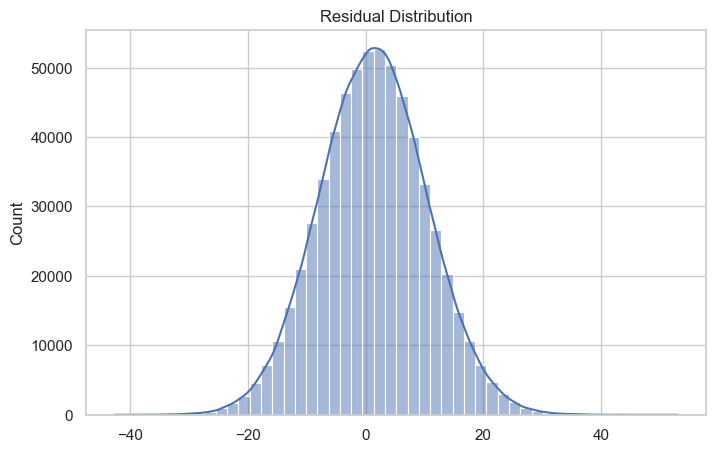

In [39]:
residuals = y_train - oof_xgb

plt.figure(figsize=(8,5))
sns.histplot(residuals, bins=50, kde=True)
plt.title("Residual Distribution")
plt.show()

#### Predicted vs True

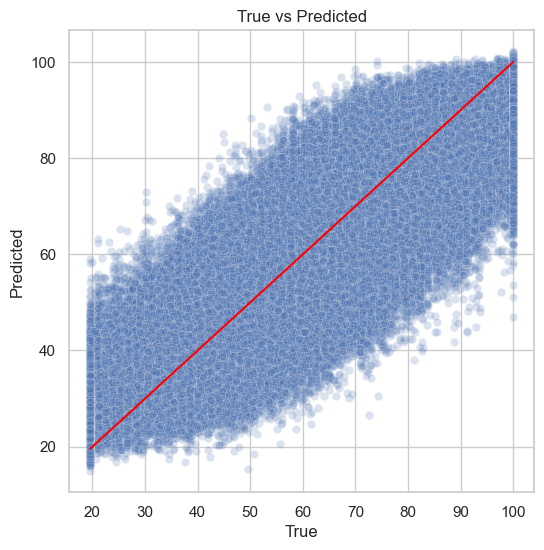

In [40]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_train, y=oof_xgb, alpha=0.2)
plt.plot([y_train.min(), y_train.max()],
         [y_train.min(), y_train.max()],
         color="red")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.title("True vs Predicted")
plt.show()

#### Learning Curve

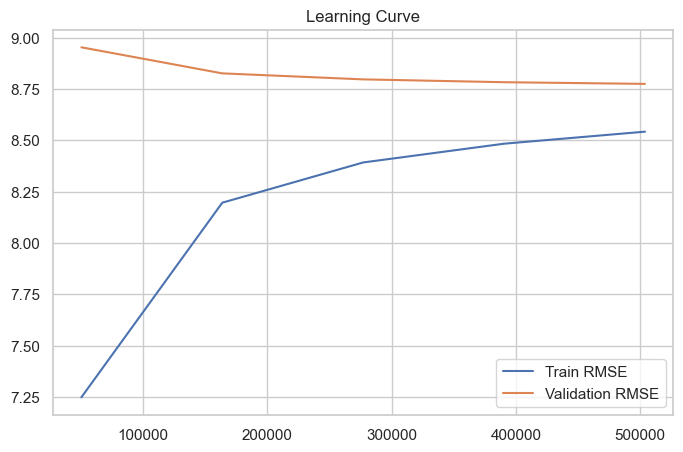

In [41]:
from sklearn.model_selection import learning_curve

model = lgb.LGBMRegressor(**lgb_params)

train_sizes, train_scores, val_scores = learning_curve(
    model,
    X_train,
    y_train,
    cv=5,
    scoring='neg_root_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 5),
    n_jobs=1
)

train_rmse = -train_scores.mean(axis=1)
val_rmse = -val_scores.mean(axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_rmse, label="Train RMSE")
plt.plot(train_sizes, val_rmse, label="Validation RMSE")
plt.legend()
plt.title("Learning Curve")
plt.show()

## 13. Submission file